<a href="https://colab.research.google.com/github/SergeiGrudinin/deeplearning-beginners/blob/master/notebook/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks on MNIST

This notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The code below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [21]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

def dodo():
    print("Hello World")
    return 0

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':

    dodo()
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('https://github.com/SergeiGrudinin/mnist/raw/master/t10k-labels-idx1-ubyte.gz'))
    )

Hello World


The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [2]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


## Visualize the dataset

0


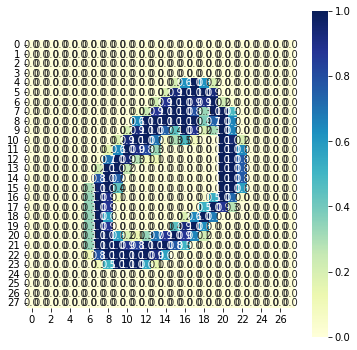

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i=1

data = np.load('mnist.npz')
image = data['train_x'][i]
# image = np.rot90(image)
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

## Perceptron algorithm for single-layer neural network

In [4]:
import numpy as np

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))         # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]        # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])   # (60000 x 785)
Ytrain = data['train_y']                    # (60000)
Xtest = image_to_vector(data['test_x'])     # (10000 x 785)
Ytest = data['test_y']                      # (10000)


# import matplotlib.pyplot as plt
# plt.plot(Xtrain[1])
# plt.show()

W = np.random.randn(10, 28*28+1)            # (10 x 785)

eta = 0.001
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
    
    print('#{}: train_accuracy={:.4f}, test_accuracy={:.4f}'.format(
        t,
        float(num_correct_train) / len(Ytrain),
        float(num_correct_test) / len(Ytest)
    ))

#0: train_accuracy=0.5667, test_accuracy=0.7506
#1: train_accuracy=0.7734, test_accuracy=0.8098
#2: train_accuracy=0.8127, test_accuracy=0.8313
#3: train_accuracy=0.8307, test_accuracy=0.8445
#4: train_accuracy=0.8414, test_accuracy=0.8516
#5: train_accuracy=0.8488, test_accuracy=0.8573
#6: train_accuracy=0.8540, test_accuracy=0.8593
#7: train_accuracy=0.8585, test_accuracy=0.8626
#8: train_accuracy=0.8619, test_accuracy=0.8639
#9: train_accuracy=0.8645, test_accuracy=0.8659
#10: train_accuracy=0.8664, test_accuracy=0.8698
#11: train_accuracy=0.8684, test_accuracy=0.8717
#12: train_accuracy=0.8702, test_accuracy=0.8731
#13: train_accuracy=0.8722, test_accuracy=0.8738
#14: train_accuracy=0.8732, test_accuracy=0.8746
#15: train_accuracy=0.8744, test_accuracy=0.8757
#16: train_accuracy=0.8757, test_accuracy=0.8763
#17: train_accuracy=0.8771, test_accuracy=0.8776
#18: train_accuracy=0.8781, test_accuracy=0.8775
#19: train_accuracy=0.8787, test_accuracy=0.8776
#20: train_accuracy=0.8800, te

In [5]:
np.save("model",W)

## Stochastic gradient descent for single-layer neural network

From now on, we will use one-hot encoding and cross-entropy loss function :

We will represent our data in the following way:
<div>
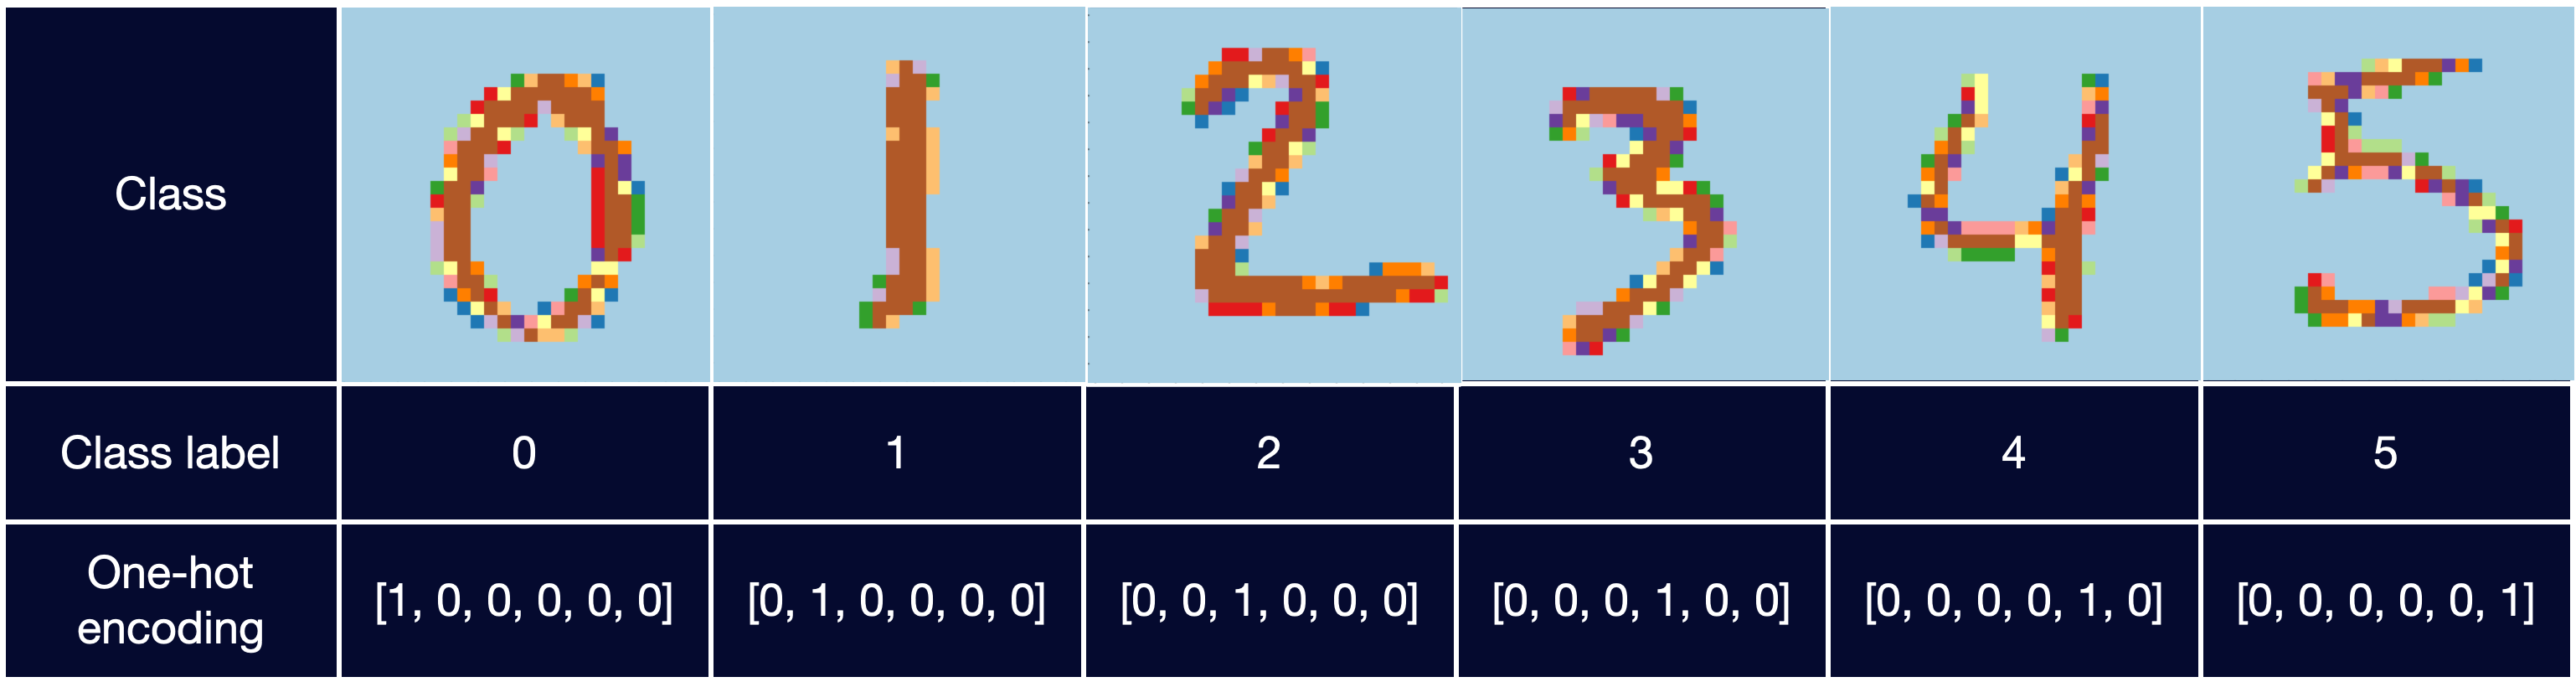
</div>


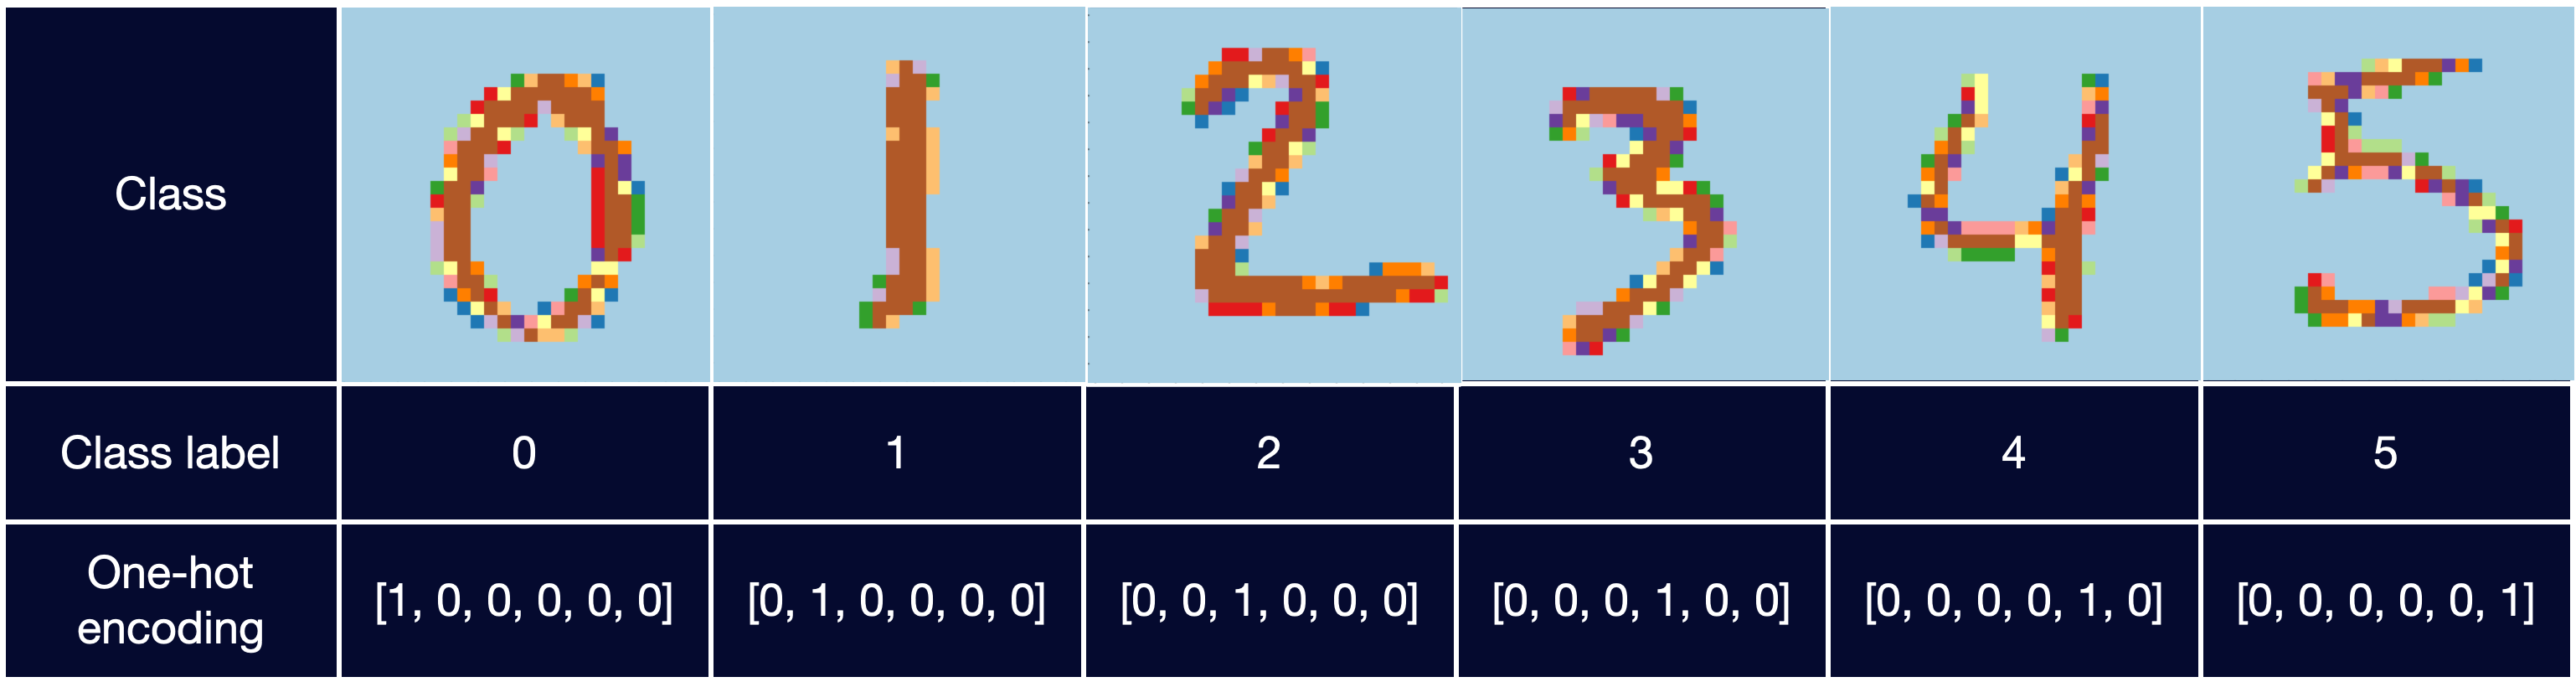


We will also use the Loss function with "t" true and "p" predicted probability vectors:
$Loss(\vec t, \vec p) = -\sum_{j=1}^N t_j \log p_j$

Some idea about the logarithm function behaviour:
<div>
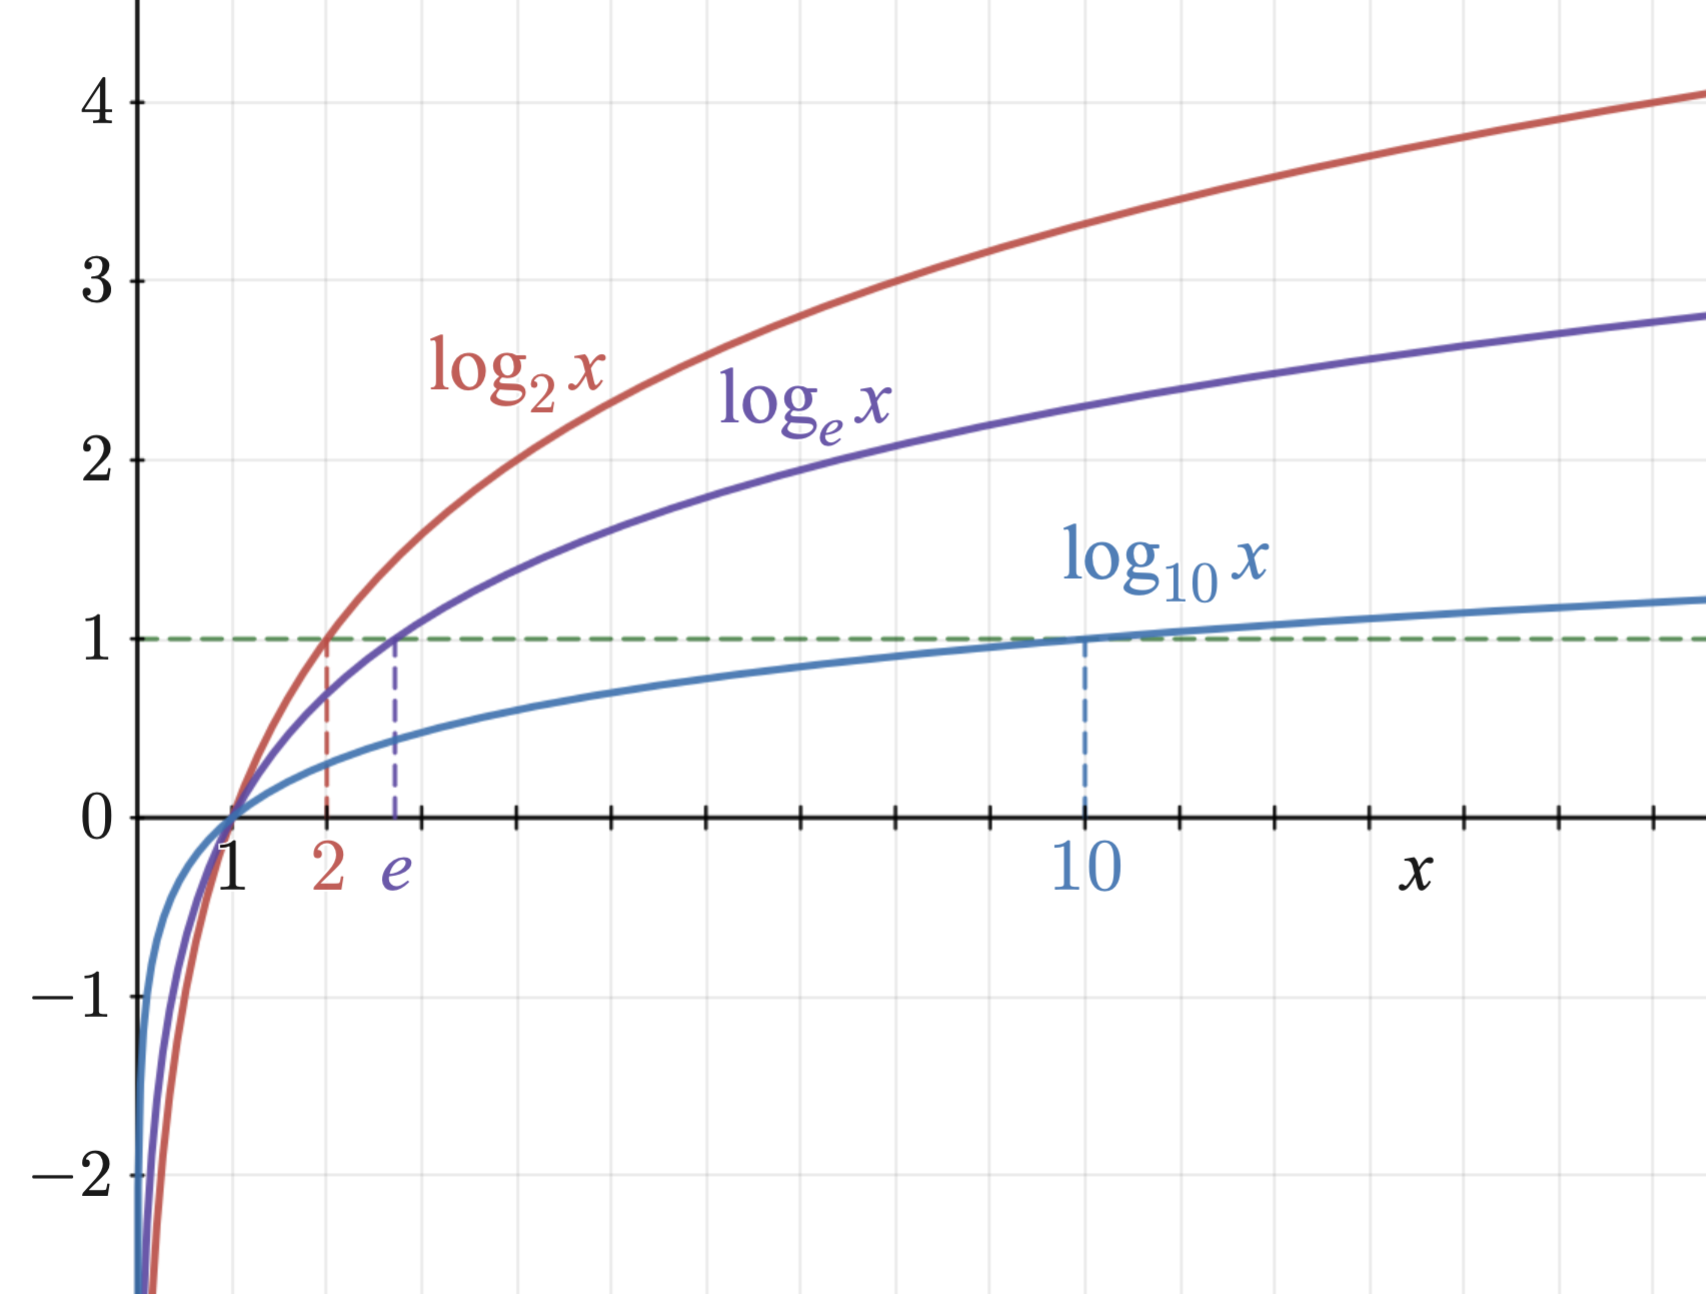
</div>

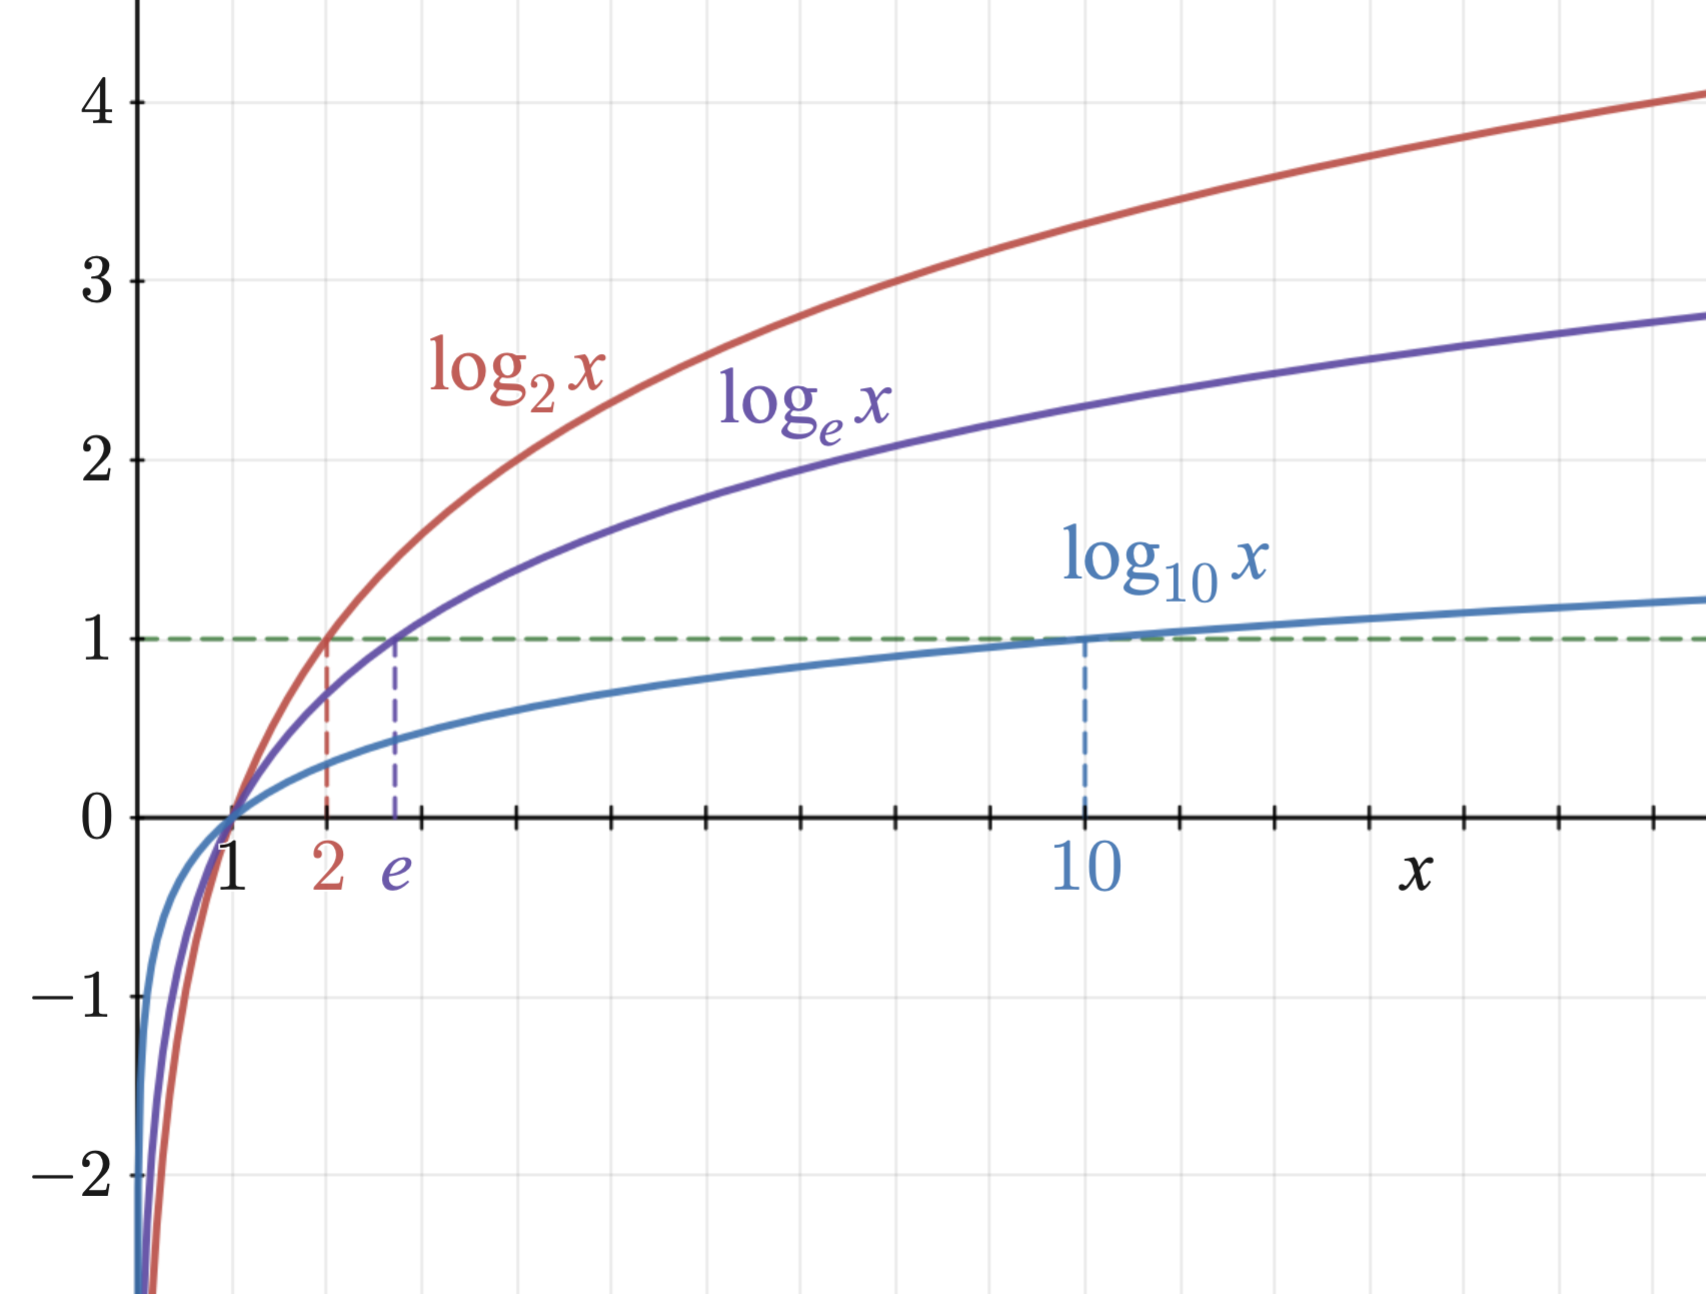

Please note, the vecors sum up to 1! (they are class probabilities!) Below, you can see some exmaple of the  Loss values:

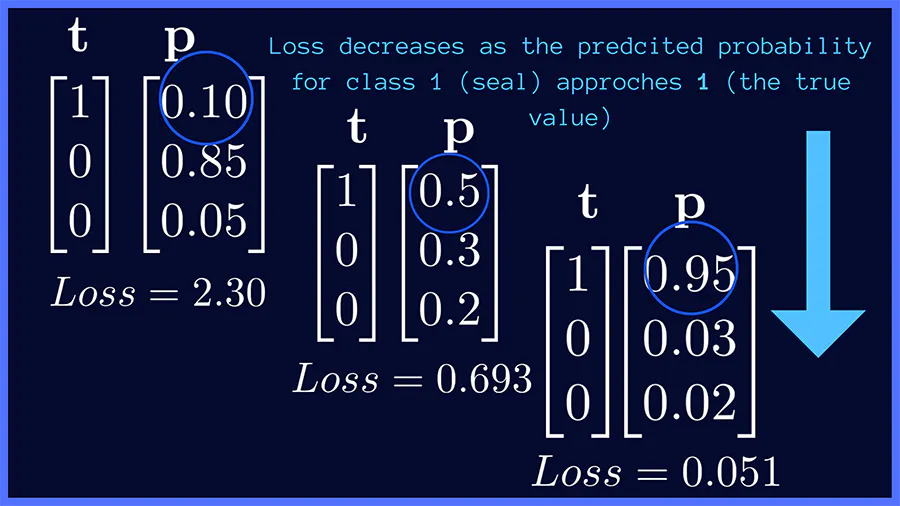

### And now the code

In [29]:
import numpy as np

def softmax(x):
    # We subtract the maximum value to prevent overflow and underflow problems, 
    # (result of softmax are invariant even if we add/subtract a constant)
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])       # (60000 x 785)
Ytrain = label_to_onehot(data['train_y'], 10)   # (60000 x 10)
Xtest = image_to_vector(data['test_x'])         # (10000 x 785)
Ytest = data['test_y']                          # (10000) (not one-hot encoding)

W = np.random.randn(10, 28*28+1)                # (10 x 785)

eta = 0.1
for t in range(100):
    loss = 0.
    num_correct_train = 0
    
    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))                              # Here, we change argmax into probability distribution
        loss += -np.log(y_pred[np.argmax(y)])                       # Here, we compute the Loss, - t log p, where t = 1
        W += np.outer(eta * (y - y_pred), x)    # np.outer: out[i,j] = a[i]*b[j] and modify the weights matrix!
        if np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1
    
    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
            
    print('#{}: loss={:.2f}, train_accuracy={:.4f}, test_accuracy={:.4f}'.format(
        t,
        loss / len(Ytrain),
        float(num_correct_train) / len(Ytrain),
        float(num_correct_test) / len(Ytest)
    ))

#0: loss=1.03, train_accuracy=0.8642, test_accuracy=0.8703
#1: loss=0.87, train_accuracy=0.8853, test_accuracy=0.8630
#2: loss=0.83, train_accuracy=0.8897, test_accuracy=0.8788
#3: loss=0.81, train_accuracy=0.8926, test_accuracy=0.8595
#4: loss=0.80, train_accuracy=0.8946, test_accuracy=0.8734
#5: loss=0.79, train_accuracy=0.8940, test_accuracy=0.8762
#6: loss=0.79, train_accuracy=0.8948, test_accuracy=0.8723
#7: loss=0.78, train_accuracy=0.8968, test_accuracy=0.8766
#8: loss=0.78, train_accuracy=0.8955, test_accuracy=0.8684
#9: loss=0.77, train_accuracy=0.8975, test_accuracy=0.8639
#10: loss=0.77, train_accuracy=0.8980, test_accuracy=0.8735
#11: loss=0.77, train_accuracy=0.8977, test_accuracy=0.8712
#12: loss=0.77, train_accuracy=0.8978, test_accuracy=0.8729
#13: loss=0.77, train_accuracy=0.8980, test_accuracy=0.8724
#14: loss=0.76, train_accuracy=0.8995, test_accuracy=0.8770
#15: loss=0.76, train_accuracy=0.8994, test_accuracy=0.8673
#16: loss=0.76, train_accuracy=0.8989, test_accura

## Training with pytorch

### Veryfing hardware acceleration

In [15]:
!pip install torch 
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


[notice] A new release of pip available: 22.3 -> 24.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Using device: cpu



### Activate TensorBoard

Usage from PyTorch: https://pytorch.org/docs/stable/tensorboard.html

In [20]:
# Uncomment these lines when you use TensorBoard.
%load_ext tensorboard
%tensorboard --logdir ./runs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16898), started 0:00:15 ago. (Use '!kill 16898' to kill it.)

### Convert the numpy arrays into pytorch tensor

In [16]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

### Single-layer neural network

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np

#device = torch.device("cpu") # Uncomment this to run on CPU
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# setting device on GPU if available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()

ac_train = []
ac_test = []
loss_train = []
loss_test = []

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

writer = SummaryWriter(comment="single-layer")
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)                                       # this is a way to copy data from the main memory to CPU, GPU or other devices
        y_pred = model(x)                                                       # this is equivalent to the previous y_pred = dot_product (W,x)
        _, predicted = torch.max(y_pred.data, 1)                                # it returns a tuple (max, argmax)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Record loss and accuracy values on the training and test sets.
    writer.add_scalars('loss', {'train': train_loss, 'test': test_loss}, t)
    writer.add_scalars('accuracy', {'train': train_correct, 'test': test_correct}, t)

    # Report progress (comment out the following line when you use TensorBoard).
    print('#{}: loss_test={:.4f}, loss_train={:.4f}, acc_test={:.4f}, acc_train={:.4f}'.format(
        t,
        test_loss,
        train_loss,
        test_correct,
        train_correct
    ))

    #this part is for pyplot
    ac_train.append(test_correct)
    ac_test.append(train_correct)
    loss_train.append(train_loss)
    loss_test.append(test_loss)
writer.close()

Sequential(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
#0: loss_test=0.0167, loss_train=0.0088, acc_test=0.4673, acc_train=0.2300
#1: loss_test=0.0151, loss_train=0.0079, acc_test=0.6653, acc_train=0.5826
#2: loss_test=0.0138, loss_train=0.0072, acc_test=0.7290, acc_train=0.6948
#3: loss_test=0.0126, loss_train=0.0066, acc_test=0.7580, acc_train=0.7366
#4: loss_test=0.0117, loss_train=0.0061, acc_test=0.7791, acc_train=0.7587
#5: loss_test=0.0109, loss_train=0.0056, acc_test=0.7907, acc_train=0.7725
#6: loss_test=0.0102, loss_train=0.0053, acc_test=0.8015, acc_train=0.7839
#7: loss_test=0.0096, loss_train=0.0050, acc_test=0.8088, acc_train=0.7921
#8: loss_test=0.0091, loss_train=0.0047, acc_test=0.8152, acc_train=0.7992
#9: loss_test=0.0087, loss_train=0.0045, acc_test=0.8203, acc_train=0.8054
#10: loss_test=0.0083, loss_train=0.0043, acc_test=0.8229, acc_train=0.8099
#11: loss_test=0.0080, loss_train=0.0041, acc_test=0.8267, acc_train=0.8139
#12: loss_test=0.0077, 

Here we can see the training results, either using TensorBoard, or simply with matplotlib:

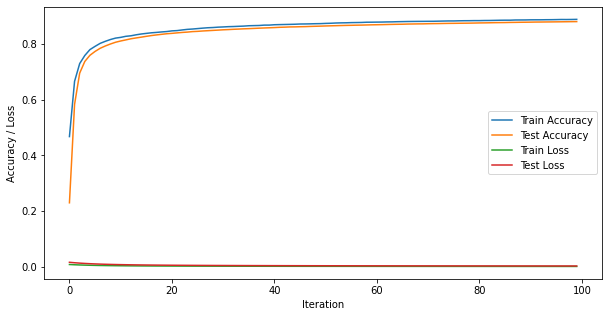

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(ac_train,label="Train Accuracy")
plt.plot(ac_test,label="Test Accuracy")
plt.plot(loss_train,label="Train Loss")
plt.plot(loss_test,label="Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Accuracy / Loss")
plt.legend()
plt.show()

### Three-layer neural network

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np

#device = torch.device("cpu") # Uncomment this to run on CPU
#device = torch.device("cuda:0") # Uncomment this to run on GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

writer = SummaryWriter(comment="two-layer")
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Record loss and accuracy values on the training and test sets.
    writer.add_scalars('loss', {'train': train_loss, 'test': test_loss}, t)
    writer.add_scalars('accuracy', {'train': train_correct, 'test': test_correct}, t)

    # Report progress (comment out the following line when you use TensorBoard).
    print('#{}: loss_test={:.4f}, loss_train={:.4f}, acc_test={:.4f}, acc_train={:.4f}'.format(
        t,
        test_loss,
        train_loss,
        test_correct,
        train_correct
    ))

writer.close()

Using device: cpu

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
#0: loss_test=0.0034, loss_train=0.0048, acc_test=0.8782, acc_train=0.6292
#1: loss_test=0.0023, loss_train=0.0019, acc_test=0.9134, acc_train=0.8582
#2: loss_test=0.0019, loss_train=0.0015, acc_test=0.9267, acc_train=0.8905
#3: loss_test=0.0016, loss_train=0.0012, acc_test=0.9387, acc_train=0.9063
#4: loss_test=0.0014, loss_train=0.0011, acc_test=0.9484, acc_train=0.9198
#5: loss_test=0.0012, loss_train=0.0010, acc_test=0.9526, acc_train=0.9286
#6: loss_test=0.0011, loss_train=0.0009, acc_test=0.9545, acc_train=0.9352
#7: loss_test=0.0011, loss_train=0.0008, acc_test=0.9578, acc_train=0.9389
#8: loss_test=0.0010, loss_train=0.0008, acc_test=0.9611, 

### Convolutional Neural Network (CNN)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np

#device = torch.device("cpu") # Uncomment this to run on CPU
#device = torch.device("cuda:0") # Uncomment this to run on GPU

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

writer = SummaryWriter(comment="CNN")
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Record loss and accuracy values on the training and test sets.
    writer.add_scalars('loss', {'train': train_loss, 'test': test_loss}, t)
    writer.add_scalars('accuracy', {'train': train_correct, 'test': test_correct}, t)

    # Report progress (comment out the following line when you use TensorBoard).
    print('#{}: loss_test={:.4f}, loss_train={:.4f}, acc_test={:.4f}, acc_train={:.4f}'.format(
        t,
        test_loss,
        train_loss,
        test_correct,
        train_correct
    ))

writer.close()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten()
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=256, out_features=10, bias=True)
)
#0: loss_test=0.0020, loss_train=0.0044, acc_test=0.9339, acc_train=0.6125
#1: loss_test=0.0011, loss_train=0.0014, acc_test=0.9614, acc_train=0.8878
#2: loss_test=0.0008, loss_train=0.0010, acc_test=0.9709, acc_train=0.9190
#3: loss_test=0.0007, loss_train=0.0008, acc_test=0.9727, acc_train=0.9324
#4: loss_test=0.0006, loss_train=0.0007, acc_test=0.9764, acc_train=0.9409
#5: loss_test=0.0005, loss_train=0.0007, a